In [1]:
%reload_ext autoreload
#%load_ext autoreload
%autoreload 1
%matplotlib inline

import datetime
import pandas as pd
#import modin.pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from tqdm import tqdm
import pyreadstat


#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn.preprocessing import FunctionTransformer, StandardScaler, QuantileTransformer,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope, EmpiricalCovariance, MinCovDet
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering

from umap import UMAP
from sklearn.decomposition import PCA, FactorAnalysis, NMF, SparseCoder, SparsePCA
from sklearn.pipeline import Pipeline

from scipy.stats import chi2

import os
import sys
import gc
import joblib

os.chdir("T:\\laupodteam\\AIOS\\Bram\\notebooks\\code_dev\\celldyn_embedder\\sandbox")
#os.chdir("/media/UMCU/notebooks/code_dev/celldyn_embedder/sandbox")
sns.set_style("whitegrid")

write_to_disk = False
read_from_disk = True

from numba import jit, njit, float32
from functools import lru_cache, cached_property
from numpy import linalg as la
from collections import defaultdict
#import ray
#ray.init()

from hembedder.utils.distance import poincarre_dist, fractional_distance, hyperboloid_dist, Distance
from hembedder.prepping import quality
from hembedder.prepping import transformer
from hembedder.prepping import recombinator
from hembedder.prepping import imputer

In [2]:
allinity = pd.read_sas('T://laupodteam/AIOS/Chontira/data/data_20230727/compstud_dle_alin_20230727.sas7bdat')
allinity = allinity.dropna(subset=['fcs_id'])
allinity = allinity[~allinity.fcs_id.duplicated()]

In [3]:
sapphire = pd.read_sas('T://laupodteam/AIOS/Chontira/data/data_20230727/compstud_dle_sapph_20230727.sas7bdat')
sapphire = sapphire.dropna(subset=['fcs_id'])
sapphire = sapphire[~sapphire.fcs_id.duplicated()]

In [4]:
_, allinity_meta = pyreadstat.read_sas7bdat('T://laupodteam/AIOS/Chontira/data/data_20230727/compstud_dle_alin_20230727.sas7bdat', metadataonly=True)
_, sapphire_meta = pyreadstat.read_sas7bdat('T://laupodteam/AIOS/Chontira/data/data_20230727/compstud_dle_sapph_20230727.sas7bdat', metadataonly=True)

In [5]:
allinity['afname_date'] = allinity.afname_dt.dt.date
allinity['day_of_week'] = allinity.afname_dt.dt.dayofweek
allinity['week_of_year'] = allinity.afname_dt.dt.weekofyear
allinity['year'] = allinity.afname_dt.dt.year

sapphire['afname_date'] = sapphire.afname_dt.dt.date
sapphire['day_of_week'] = sapphire.afname_dt.dt.dayofweek
sapphire['week_of_year'] = sapphire.afname_dt.dt.weekofyear
sapphire['year'] = sapphire.afname_dt.dt.year

C:\Users\bes3\AppData\Local\Temp/ipykernel_6228/428115150.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  allinity['week_of_year'] = allinity.afname_dt.dt.weekofyear
C:\Users\bes3\AppData\Local\Temp/ipykernel_6228/428115150.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  sapphire['week_of_year'] = sapphire.afname_dt.dt.weekofyear


In [6]:
meas_col_dict = dict()
flag_col_dict = dict()
meas_col_dict['allinity'] = [c for c in allinity.columns if 'c_b' in c]
flag_col_dict['allinity'] = [c for c in allinity.columns if 'c_s' in c]

meas_col_dict['sapphire'] = [c for c in sapphire.columns if 'c_b' in c]
flag_col_dict['sapphire'] = [c for c in sapphire.columns if 'c_s' in c]

In [7]:
def clip_outliers(df, cols, qL=0.01, qH=0.99):
    df_ = df.copy()
    for col in cols:
        df_[col] = df[col].clip(df[col].quantile(qL), df[col].quantile(qH))
    return df

In [8]:
allinity['plr'] = allinity['c_b_plt'] / allinity['c_b_lym']
allinity['nlr'] = allinity['c_b_neu'] / allinity['c_b_lym']

sapphire['plr'] = sapphire['c_b_plt'] / sapphire['c_b_lym']
sapphire['nlr'] = sapphire['c_b_neu'] / sapphire['c_b_lym']

In [9]:
allinity['ANY_SUSPECT_FLAGS']= (allinity[flag_col_dict['allinity']]==2).sum(axis=1)
sapphire['ANY_SUSPECT_FLAGS']= (sapphire[flag_col_dict['sapphire']]==2).sum(axis=1)

In [10]:
allinity_clipped = clip_outliers(allinity, meas_col_dict['allinity'], qL=0.05, qH=0.95)
sapphire_clipped = clip_outliers(sapphire, meas_col_dict['sapphire'], qL=0.05, qH=0.95)

In [11]:
# c_b_plt drops around 2021-05
# seems to be a weekly pattern?

In [12]:
[c for c in allinity.columns if 'f' in c]

['fcs_id',
 'c_b_wvf',
 'c_s_wvf',
 'c_b_irf',
 'c_s_irf',
 'HGB_Interf_Flag',
 'Left_Shift_Flag',
 'HGB_Reference_Out_of_Range',
 'MCHC_Out_of_Range',
 'HGB_Channel_Out_Of_Range',
 'Lower_PLT_Interference',
 'Upper_PLT_Interference',
 'afname_dt',
 'afname_date',
 'day_of_week',
 'week_of_year']

<AxesSubplot:xlabel='week_of_year', ylabel='c_b_plt'>

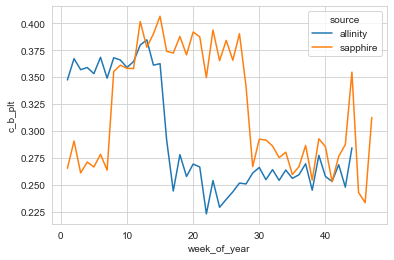

In [76]:
var = 'c_b_plt'

plot_df_all = allinity_clipped.query('ANY_SUSPECT_FLAGS==0 & year==2021 & week_of_year<52')\
                                .groupby(['week_of_year']).agg({var: lambda x: sum(x>300)/len(x)}).reset_index()
plot_df_all['source'] = 'allinity'

plot_df_sapp = sapphire_clipped.query('ANY_SUSPECT_FLAGS==0 & year==2021 & week_of_year<52')\
                                .groupby(['week_of_year']).agg({var: lambda x: sum(x>300)/len(x)}).reset_index()
plot_df_sapp['source'] = 'sapphire'

plot_df = pd.concat([plot_df_all, plot_df_sapp], axis=0)

sns.lineplot(data=plot_df, x='week_of_year', y=var, hue='source')


In [27]:
allinity_clipped = allinity_clipped.assign(Analyzer=allinity_clipped.Analyzer.str.decode('latin-1'))

C:\Users\bes3\AppData\Local\Temp/ipykernel_6228/293996354.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  allinity_clipped['weekofyear'] = allinity_clipped.afname_dt.dt.week


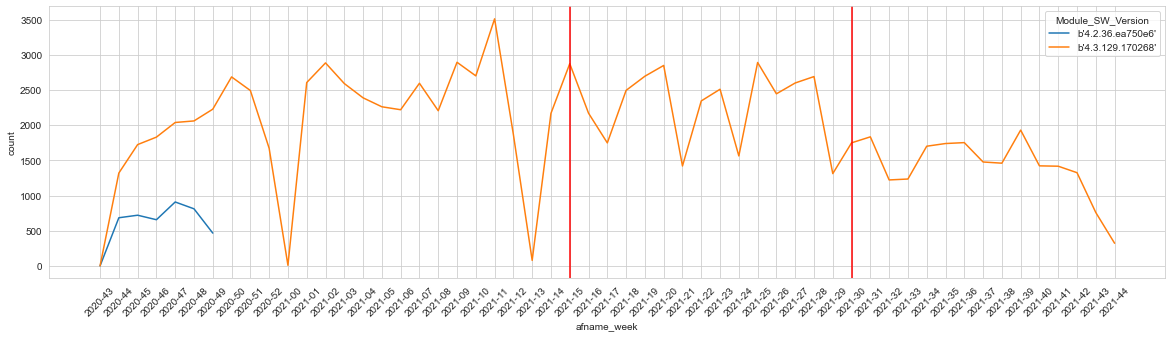

In [66]:
cat = 'Module_SW_Version' # Module_SW_Version, Analyzer
allinity_clipped['weekofyear'] = allinity_clipped.afname_dt.dt.week
allinity_clipped['year'] = allinity_clipped.afname_dt.dt.year
# represent datetime in week frequency
allinity_clipped['afname_week'] = allinity_clipped.afname_dt.dt.strftime('%Y-%W')

res = allinity_clipped.groupby(['afname_week', cat]).size().reset_index().rename(columns={0:'count'})

fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=res, x='afname_week', y='count', hue=cat)

# rotate xticks with 45 degrees
plt.xticks(rotation=45);
plt.axvline('2021-15', color='red')
plt.axvline('2021-30', color='red')

C:\Users\bes3\AppData\Local\Temp/ipykernel_6228/987504361.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  sapphire_clipped['weekofyear'] = sapphire_clipped.afname_dt.dt.week


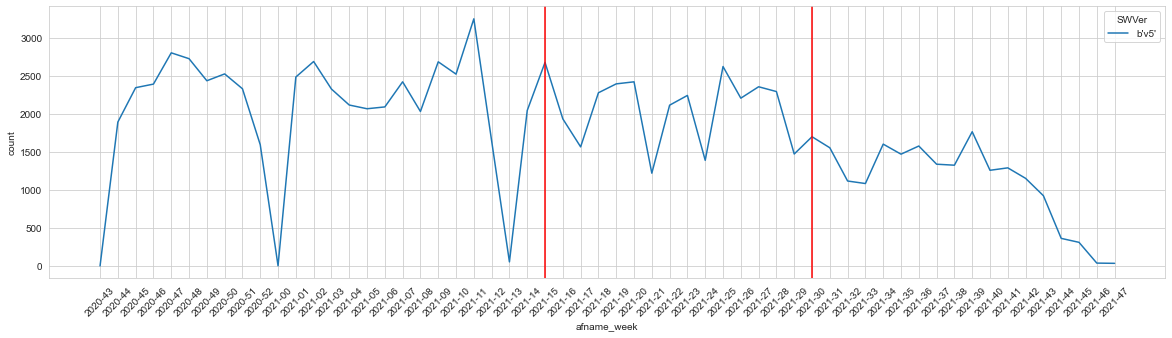

In [69]:
cat = 'SWVer' # Module_SW_Version, Analyzer
sapphire_clipped['weekofyear'] = sapphire_clipped.afname_dt.dt.week
sapphire_clipped['year'] = sapphire_clipped.afname_dt.dt.year
# represent datetime in week frequency
sapphire_clipped['afname_week'] = sapphire_clipped.afname_dt.dt.strftime('%Y-%W')

res = sapphire_clipped.groupby(['afname_week', cat]).size().reset_index().rename(columns={0:'count'})

fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=res, x='afname_week', y='count', hue=cat)

# rotate xticks with 45 degrees
plt.xticks(rotation=45);
plt.axvline('2021-15', color='red')
plt.axvline('2021-30', color='red')

In [105]:
meas_cols = list(set(meas_col_dict['sapphire']).intersection(set(meas_col_dict['allinity'])))

In [106]:
all_df = allinity_clipped[meas_cols+['afname_week']]
all_df['ds'] = 'allinity'

sap_df = sapphire_clipped[meas_cols+['afname_week']]
sap_df['ds'] = 'sapphire'

total_df = pd.concat([all_df, sap_df], axis=0)

C:\Users\bes3\AppData\Local\Temp/ipykernel_6228/2980325146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df['ds'] = 'allinity'
C:\Users\bes3\AppData\Local\Temp/ipykernel_6228/2980325146.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sap_df['ds'] = 'sapphire'


In [107]:
total_df = total_df.dropna(subset=meas_cols) 
total_pca_df = PCA(n_components=10).fit_transform(total_df[meas_cols])

In [108]:
pca_df = pd.DataFrame(data=total_pca_df, columns=[f'pc_{c}' for c in range(0,10)])
pca_df['afname_week'] = total_df.afname_week.values
pca_df['ds'] = total_df.ds.values

(-50.0, 50.0)

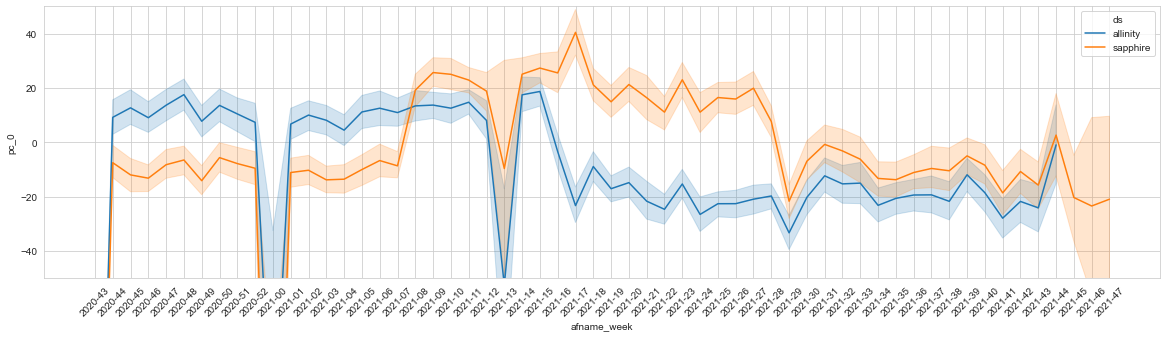

In [114]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=pca_df, x='afname_week', y='pc_0', hue='ds')

# rotate xticks with 45 degrees
plt.xticks(rotation=45);
plt.ylim(-50,50)

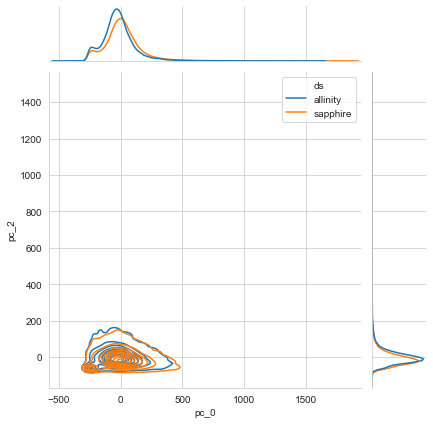

In [123]:
sns.jointplot(data=pca_df.query('"2021-30">afname_week>"2021-15"'), x='pc_0', y='pc_2', hue='ds', kind='kde')